# Dataset Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report
import os
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
from tqdm import tqdm

In [ ]:
!pip install rarfile

In [ ]:
import zipfile
import rarfile
import os


In [ ]:
import zipfile
import os

# Define the zip file path and the target extraction folder
zip_path = "Parkinson DATASET.zip"
extract_to = "Parkinson DATASET"

# Extract all files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Walk through the directory and print all file paths
print("Contents of the unzipped folder:\n")
for root, dirs, files in os.walk(extract_to):
    for file in files:
        print(os.path.join(root, file))

Contents of the unzipped folder:

Parkinson DATASET/Parkinson_Multiple_Sound_Recording.rar
Parkinson DATASET/Extracted/test_data.txt
Parkinson DATASET/Extracted/train_data.txt


In [ ]:
import zipfile
import rarfile
import os

# Step 1: Extract ZIP
zip_path = "Parkinson DATASET.zip"
extract_to = "Parkinson DATASET"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("ZIP Extracted. Now checking for RAR files...")

# Step 2: Extract RAR
rar_path = os.path.join(extract_to, "Parkinson_Multiple_Sound_Recording.rar")
rar_extract_to = os.path.join(extract_to, "Extracted")

if os.path.exists(rar_path):
    rf = rarfile.RarFile(rar_path)
    rf.extractall(rar_extract_to)
    print(f"Extracted RAR to: {rar_extract_to}")
else:
    print("RAR file not found!")

# Step 3: List extracted contents
print("\nContents of the fully extracted dataset:\n")
for root, dirs, files in os.walk(rar_extract_to):
    for file in files:
        print(os.path.join(root, file))


ZIP Extracted. Now checking for RAR files...
Extracted RAR to: Parkinson DATASET/Extracted

Contents of the fully extracted dataset:

Parkinson DATASET/Extracted/test_data.txt
Parkinson DATASET/Extracted/train_data.txt


In [ ]:
print("\n📁 Contents of the fully extracted dataset:\n")
for root, dirs, files in os.walk(rar_extract_to):
    for file in files:
        print(os.path.join(root, file))



📁 Contents of the fully extracted dataset:

Parkinson DATASET/Extracted/test_data.txt
Parkinson DATASET/Extracted/train_data.txt


# Data Preprocessing

In [ ]:
samples_per_subject = 26
num_features = 26

train_path = "Parkinson DATASET/Extracted/train_data.txt"
test_path = "Parkinson DATASET/Extracted/test_data.txt"


In [ ]:
train_df = pd.read_csv(train_path, header=None)
test_df = pd.read_csv(test_path, header=None)

In [ ]:
# Assign column names
train_columns = ['subject_id'] + [f'f{i+1}' for i in range(num_features)] + ['UPDRS', 'class']
test_columns  = ['subject_id'] + [f'f{i+1}' for i in range(num_features)] + ['UPDRS']  # No 'class' in test

In [ ]:
train_df.columns = train_columns
test_df.columns = test_columns


In [ ]:
print("Number of columns in the train dataset:", train_df.shape[1])

Number of columns in the train dataset: 29


In [ ]:
print("Current column names in train dataset:", train_df.columns.tolist())

Current column names in train dataset: ['subject_id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'UPDRS', 'class']


In [ ]:
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)


Train shape: (1040, 29)
Test shape : (168, 28)


In [ ]:
# Convert datatypes
train_df['subject_id'] = train_df['subject_id'].astype(int)
train_df['UPDRS'] = train_df['UPDRS'].astype(float)
train_df['class'] = train_df['class'].astype(int)

test_df['subject_id'] = test_df['subject_id'].astype(int)
test_df['UPDRS'] = test_df['UPDRS'].astype(float)


In [ ]:
#Trim to full subjects
def trim_df(df):
    trim_len = (df.shape[0] // samples_per_subject) * samples_per_subject
    return df.iloc[:trim_len]

train_df = trim_df(train_df)
test_df = trim_df(test_df)

#Prepare Features and Scale
scaler = StandardScaler()

X_train = train_df[[f'f{i+1}' for i in range(num_features)]].values
X_test  = test_df[[f'f{i+1}' for i in range(num_features)]].values

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#Reshape for LSTM
num_train_subjects = train_df.shape[0] // samples_per_subject
num_test_subjects  = test_df.shape[0] // samples_per_subject

X_train_seq = X_train_scaled.reshape(num_train_subjects, samples_per_subject, num_features)
X_test_seq  = X_test_scaled.reshape(num_test_subjects, samples_per_subject, num_features)

#Prepare Targets
y_train_class = train_df['class'].values[::samples_per_subject]
y_train_updrs = train_df['UPDRS'].values[::samples_per_subject]
y_test_updrs  = test_df['UPDRS'].values[::samples_per_subject]


In [ ]:
print("Preprocessing Complete:")
print("X_train_seq:", X_train_seq.shape)
print("X_test_seq :", X_test_seq.shape)
print("y_train_class:", y_train_class.shape)
print("y_train_updrs :", y_train_updrs.shape)
print("y_test_updrs  :", y_test_updrs.shape)


Preprocessing Complete:
X_train_seq: (40, 26, 26)
X_test_seq : (6, 26, 26)
y_train_class: (40,)
y_train_updrs : (40,)
y_test_updrs  : (6,)


# Models Building

In [ ]:
from tensorflow.keras.optimizers import Adam


In [ ]:
from tensorflow.keras.regularizers import l2


In [ ]:
def compile_and_train_lstm(model, X_train, y_train, X_val, y_val, task='classification'):
    optimizer = Adam(learning_rate=0.0003)
    model.compile(
        loss='sparse_categorical_crossentropy' if task == 'classification' else 'mse',
        optimizer=optimizer,
        metrics=['accuracy'] if task == 'classification' else ['mae']
    )
    early_stop = EarlyStopping(patience=8, restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(factor=0.4, patience=4, verbose=1)
    batch_size = 64 if task == 'classification' else 8

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=80,
        batch_size=batch_size,
        callbacks=[early_stop, lr_reduce],
        verbose=0
    )
    return model, history


In [ ]:
def compile_and_train_gru(model, X_train, y_train, X_val, y_val, task='classification'):
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        loss='sparse_categorical_crossentropy' if task == 'classification' else 'mse',
        optimizer=optimizer,
        metrics=['accuracy'] if task == 'classification' else ['mae']
    )
    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
    batch_size = 64 if task == 'classification' else 8

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop, lr_reduce],
        verbose=0
    )
    return model, history


In [ ]:
def compile_and_train_bilstm(model, X_train, y_train, X_val, y_val, task='classification'):
    optimizer = Adam(learning_rate=0.0004)
    model.compile(
        loss='sparse_categorical_crossentropy' if task == 'classification' else 'mse',
        optimizer=optimizer,
        metrics=['accuracy'] if task == 'classification' else ['mae']
    )
    early_stop = EarlyStopping(patience=9, restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(factor=0.6, patience=4, verbose=1)
    batch_size = 64 if task == 'classification' else 8

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=90,
        batch_size=batch_size,
        callbacks=[early_stop, lr_reduce],
        verbose=0
    )
    return model, history


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Dense, Dropout, Conv1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

def compile_and_train_rnn(model, X_train, y_train, X_val, y_val, task='classification'):
    optimizer = Adam(learning_rate=0.0005)

    model.compile(
        loss='sparse_categorical_crossentropy' if task == 'classification' else 'mse',
        optimizer=optimizer,
        metrics=['accuracy'] if task == 'classification' else ['mae']
    )

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
    batch_size = 128 if task == 'classification' else 8

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop, lr_reduce],
        verbose=0
    )
    return model, history

In [ ]:
def compile_and_train_densenet(model, X_train, y_train, X_val, y_val, task='classification'):
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        loss='sparse_categorical_crossentropy' if task == 'classification' else 'mse',
        optimizer=optimizer,
        metrics=['accuracy'] if task == 'classification' else ['mae']
    )
    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)
    batch_size = 128 if task == 'classification' else 8

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop, lr_reduce],
        verbose=0
    )
    return model, history


In [ ]:

from tensorflow.keras.layers import LayerNormalization
def build_lstm(input_shape, task='classification'):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=False), input_shape=input_shape),
        LayerNormalization(),
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(2 if task == 'classification' else 1, activation='softmax' if task == 'classification' else 'linear')
    ])
    return model

def build_gru(input_shape, task='classification'):
    model = Sequential([
        Bidirectional(GRU(128), input_shape=input_shape),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.3),
        Dense(2 if task == 'classification' else 1, activation='softmax' if task == 'classification' else 'linear')
    ])
    return model


def build_bilstm(input_shape, task='classification'):
    model = Sequential([
        Bidirectional(LSTM(128), input_shape=input_shape),
        Dropout(0.3),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dense(2 if task == 'classification' else 1, activation='softmax' if task == 'classification' else 'linear')
    ])
    return model

def build_rnn(input_shape, task='classification'):
    model = Sequential([
        SimpleRNN(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2, input_shape=input_shape),
        BatchNormalization(),
        SimpleRNN(64, dropout=0.3, recurrent_dropout=0.2),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(2 if task == 'classification' else 1, activation='softmax' if task == 'classification' else 'linear')
    ])
    return model


def build_densenet_1d(input_shape, task='classification'):
    model = Sequential([
        Conv1D(128, 3, padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(256, 3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(512, 3, padding='same', activation='relu'),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.3),
        Dense(2 if task == 'classification' else 1, activation='softmax' if task == 'classification' else 'linear')
    ])
    return model



In [ ]:
from sklearn.model_selection import train_test_split

# Classification
X_tr_cls, X_val_cls, y_tr_cls, y_val_cls = train_test_split(X_train_seq, y_train_class, test_size=0.2, random_state=42)

# Regression
X_tr_reg, X_val_reg, y_tr_reg, y_val_reg = train_test_split(X_train_seq, y_train_updrs, test_size=0.2, random_state=42)


In [ ]:
train_funcs = {
    'LSTM': compile_and_train_lstm,
    'GRU': compile_and_train_gru,
    'BiLSTM': compile_and_train_bilstm,
    'SimpleRNN': compile_and_train_rnn,
    'DenseNet1D': compile_and_train_densenet
}

results = {}

for name, builder in models.items():
    print(f"\nTraining {name} for classification...")
    model_cls = builder(input_shape=(26, 26), task='classification')
    model_cls, _ = train_funcs[name](model_cls, X_tr_cls, y_tr_cls, X_val_cls, y_val_cls, task='classification')
    cls_eval = model_cls.evaluate(X_train_seq, y_train_class, verbose=0)

    print(f"Training {name} for regression...")
    model_reg = builder(input_shape=(26, 26), task='regression')
    model_reg, _ = train_funcs[name](model_reg, X_tr_reg, y_tr_reg, X_val_reg, y_val_reg, task='regression')
    reg_eval = model_reg.evaluate(X_train_seq, y_train_updrs, verbose=0)

    results[name] = {
        'classification': {'loss': cls_eval[0], 'accuracy': cls_eval[1]},
        'regression': {'loss': reg_eval[0], 'mae': reg_eval[1]}
    }

# Final results
for name, res in results.items():
    print(f"\n{name} Results:")
    print(f"  Classification - Loss: {res['classification']['loss']:.4f}, Accuracy: {res['classification']['accuracy']:.4f}")
    print(f"  Regression     - Loss: {res['regression']['loss']:.4f}, MAE: {res['regression']['mae']:.4f}")



Training LSTM for classification...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00012000000569969416.

Epoch 16: ReduceLROnPlateau reducing learning rate to 4.8000001697801054e-05.
Training LSTM for regression...

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00012000000569969416.

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.8000001697801054e-05.

Training GRU for classification...

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Training GRU for regression...

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Training BiLSTM for classification...

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00023999999393709004.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00014399999636225403.
Training BiLSTM for regression...

Epoch 25: ReduceLROnPlateau reducing lear

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Training SimpleRNN for regression...

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Training DenseNet1D for classification...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Training DenseNet1D for regression...

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

LSTM Results:
  Classification - Loss: 0.4795, Accuracy: 0.7000
  Regression     - Loss: 239.7661, MAE: 11.1697

GRU Results:
  Classification - Loss: 0.5420, Accuracy: 0.8000
  Regression     - Loss: 204.4392, MAE: 8.8119

BiLSTM Results:
  Classification - Loss: 0.5481, Accuracy: 0.7250
  Regression     - Loss: 289.8911, MAE: 10.2661

SimpleRNN Results:
  Classification - Loss: 0.4371, Accuracy: 0.8750
  Regression     - Loss: 268.8399, MAE: 10.7693

DenseNet1D Results:
  Classification - Loss: 0.6957, Accuracy: 0.6250
  Regression     - Loss: 365.9513, MAE: 11.8891



LSTM Results:
  Classification - Loss: 0.4795, Accuracy: 0.7000
  Regression     - Loss: 239.7661, MAE: 11.1697

GRU Results:
  Classification - Loss: 0.5420, Accuracy: 0.8000
  Regression     - Loss: 204.4392, MAE: 8.8119

BiLSTM Results:
  Classification - Loss: 0.5481, Accuracy: 0.7250
  Regression     - Loss: 289.8911, MAE: 10.2661

SimpleRNN Results:
  Classification - Loss: 0.4371, Accuracy: 0.8750
  Regression     - Loss: 268.8399, MAE: 10.7693

DenseNet1D Results:
  Classification - Loss: 0.6957, Accuracy: 0.6250
  Regression     - Loss: 365.9513, MAE: 11.8891


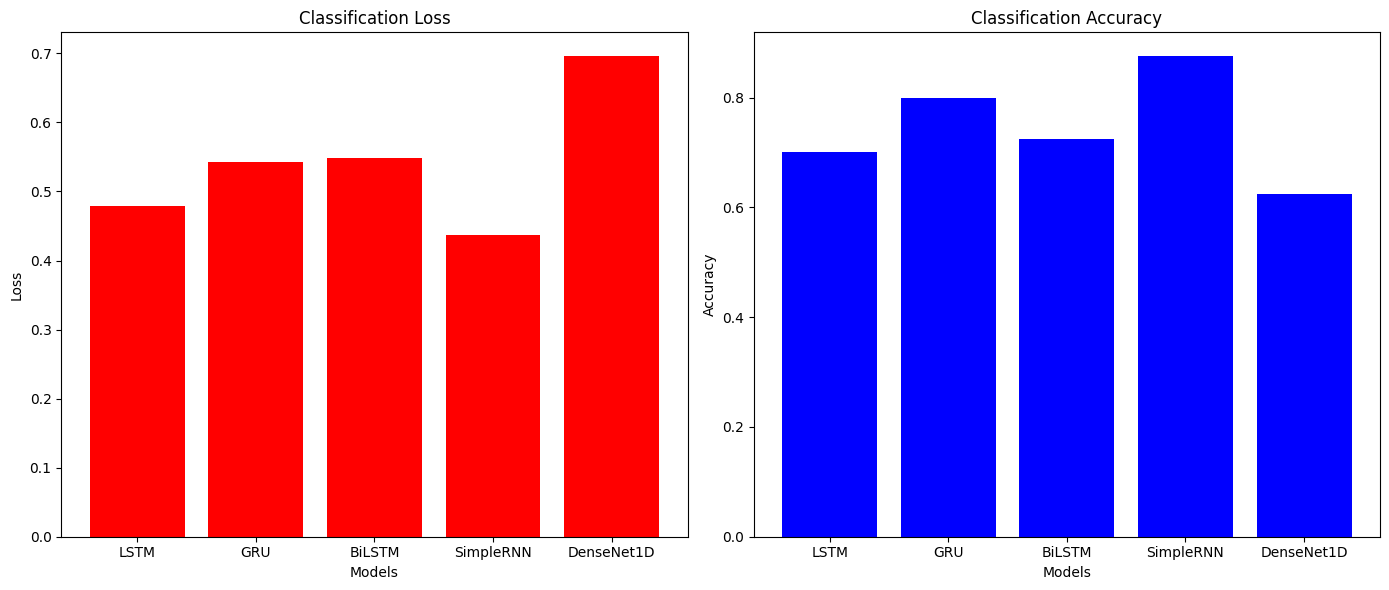

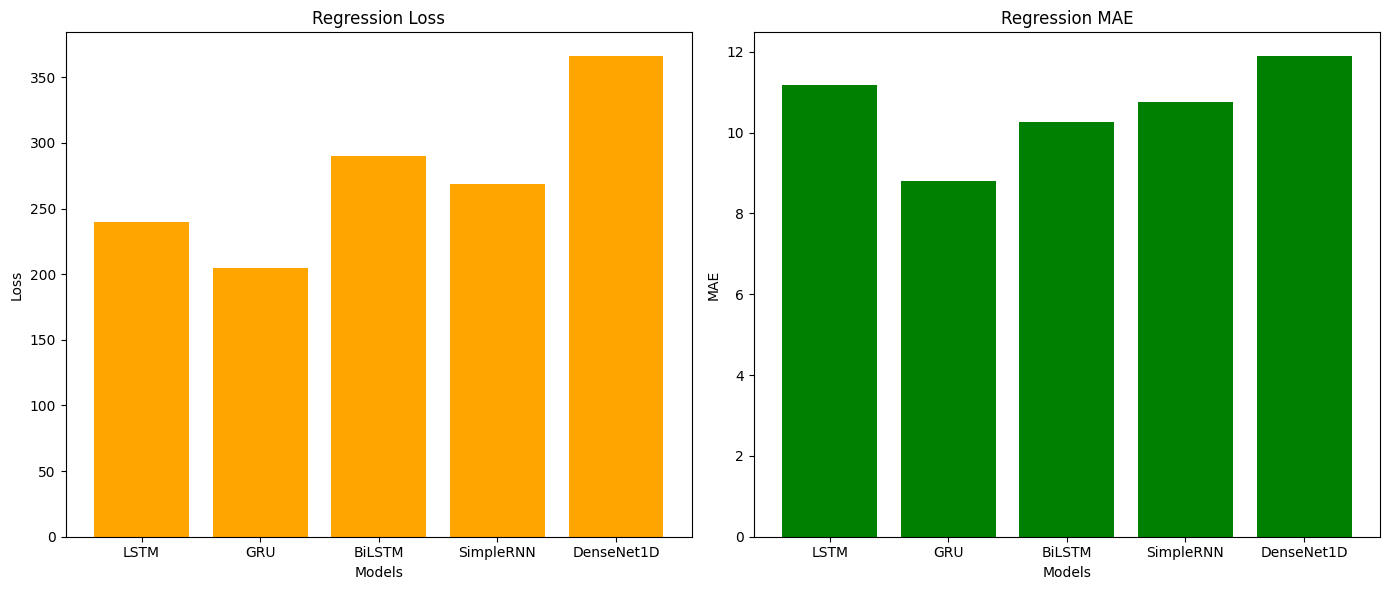

In [ ]:
for name, res in results.items():
    print(f"\n{name} Results:")
    print(f"  Classification - Loss: {res['classification']['loss']:.4f}, Accuracy: {res['classification']['accuracy']:.4f}")
    print(f"  Regression     - Loss: {res['regression']['loss']:.4f}, MAE: {res['regression']['mae']:.4f}")

# Prepare data for plotting
classification_losses = []
classification_accuracies = []
regression_losses = []
regression_maes = []
model_names = []

for name, res in results.items():
    model_names.append(name)
    classification_losses.append(res['classification']['loss'])
    classification_accuracies.append(res['classification']['accuracy'])
    regression_losses.append(res['regression']['loss'])
    regression_maes.append(res['regression']['mae'])

# Plotting Classification Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Classification Loss
axes[0].bar(model_names, classification_losses, color='red')
axes[0].set_title('Classification Loss')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Loss')

# Classification Accuracy
axes[1].bar(model_names, classification_accuracies, color='blue')
axes[1].set_title('Classification Accuracy')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Plotting Regression Loss and MAE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Regression Loss
axes[0].bar(model_names, regression_losses, color='orange')
axes[0].set_title('Regression Loss')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Loss')

# Regression MAE
axes[1].bar(model_names, regression_maes, color='green')
axes[1].set_title('Regression MAE')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MAE')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.75      0.60      0.67         5

    accuracy                           0.62         8
   macro avg       0.62      0.63      0.62         8
weighted avg       0.66      0.62      0.63         8



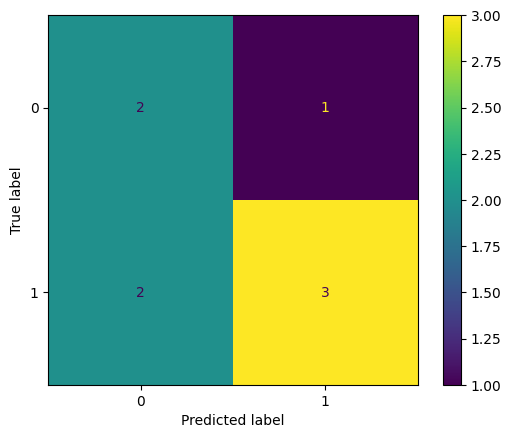

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_cls = model_cls.predict(X_val_cls).argmax(axis=1)

# Evaluation
print(classification_report(y_val_cls, y_pred_cls))
ConfusionMatrixDisplay.from_predictions(y_val_cls, y_pred_cls)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_reg = model_reg.predict(X_val_reg).flatten()

mae = mean_absolute_error(y_val_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred_reg))
r2 = r2_score(y_val_reg, y_pred_reg)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
MAE: 17.5607, RMSE: 26.3760, R²: -0.7306


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_reg = model_reg.predict(X_test_seq).flatten()

mae = mean_absolute_error(y_test_updrs, y_pred_reg)
mse = mean_squared_error(y_test_updrs, y_pred_reg)
r2 = r2_score(y_test_updrs, y_pred_reg)

print("Regression Evaluation on Test Data")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Regression Evaluation on Test Data
MAE: 0.3719
MSE: 0.1426
R²: 0.0000


In [ ]:
y_val_pred = model_cls.predict(X_val_cls)
y_val_pred_cls = np.argmax(y_val_pred, axis=1)

print(classification_report(y_val_cls, y_val_pred_cls, target_names=['Healthy', 'Parkinson']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
              precision    recall  f1-score   support

     Healthy       0.50      0.67      0.57         3
   Parkinson       0.75      0.60      0.67         5

    accuracy                           0.62         8
   macro avg       0.62      0.63      0.62         8
weighted avg       0.66      0.62      0.63         8



In [ ]:
model_cls, history_cls = compile_and_train_lstm(model_cls, X_tr_cls, y_tr_cls, X_val_cls, y_val_cls, task='classification')



Epoch 39: ReduceLROnPlateau reducing learning rate to 0.00012000000569969416.

Epoch 43: ReduceLROnPlateau reducing learning rate to 4.8000001697801054e-05.


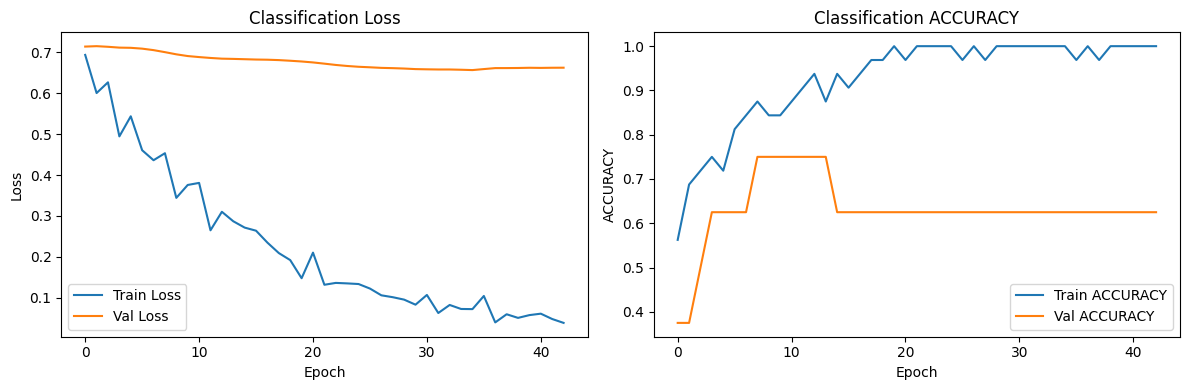

In [ ]:
plot_history(history_cls, task='classification')
